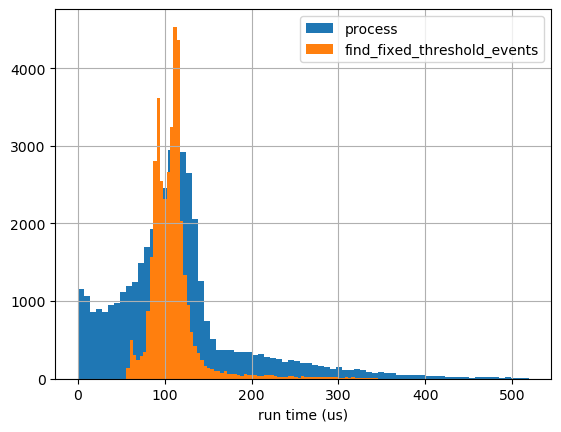

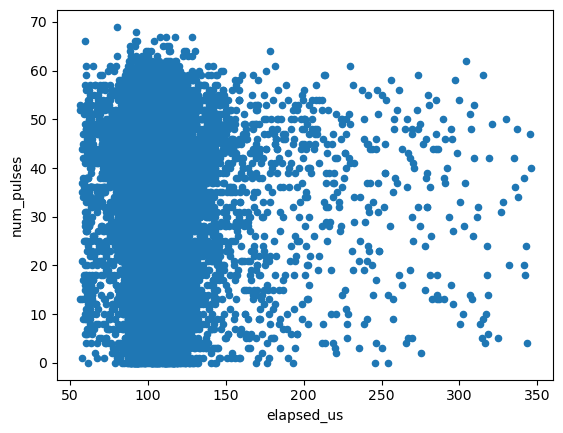

In [3]:
import json
import pandas as pd
import numpy as np

def parse_column(str):
    try:
        s = str.replace(';',',')
        return json.loads(s)
    except Exception as e:
        print(e)
        return None

df = pd.read_csv("../event-formation.csv", converters={'metadata': parse_column, 'elapsed_ns': lambda x: np.uint64(x)})
id_to_idx = {}
id_to_children = {}

for idx, row in df.iterrows():
    id_to_idx[row.id] = idx
    if id_to_children.get(row.parent_id) == None:
        id_to_children[row.parent_id] = []
    id_to_children[row.parent_id].append(row.id)

# todo: search for a row with a specific `row.span_name`, obtain the `row.id`,
# and use `id_to_children[row.id]` to traverse the call graph.


def filter_span(df, span_name, quantile=0.99):
    df = df[df["span_name"]==span_name]
    q = df["elapsed_ns"].quantile(quantile)
    return df[df["elapsed_ns"] < q]

def append_elapses_us(df):
    return df.assign(elapsed_us = df["elapsed_ns"]/1000)

def plot_hist_us(df):
    h = df["elapsed_us"].hist(bins=75)
    return h

data = filter_span(df,"process")
data = append_elapses_us(data)
plot_hist_us(data)

data = filter_span(df,"find_fixed_threshold_events")
data = append_elapses_us(data)
h = plot_hist_us(data)

h.set_xlabel("run time (us)")
h.legend(["process","find_fixed_threshold_events"])

def plot_hist_by_pulse_us(df):
    num_pulses = pd.Series([int(row['num_pulses']) for row in df["metadata"]])
    df = df.assign(num_pulses = num_pulses)
    df.plot.scatter("elapsed_us","num_pulses")

plot_hist_by_pulse_us(data)